In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return x ** 3 + x - 3 * x

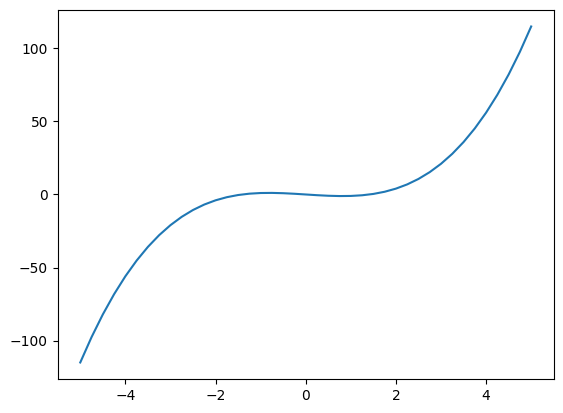

In [3]:
xs = np.arange(-5, 5.25, .25)
ps = f(xs)
plt.plot(xs, ps)

In [4]:
h = .0000001
x = 5
(f(x+h)-f(x))/h

73.00000177679067

In [5]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None # this function will automatically calls backward(). initially called at L._backward()
                                  # goal is to assign children's gradient
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    # to add constants
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      # + just routes the gradient to children
      # += signifies gradient accumulation from diff paths
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      # simple chain rule
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward

    return out


  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def __rmul__(self, other): # other * mul, but other was a constant
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      # simple chain rule
      self.grad += (1 - t**2) * out.grad

    out._backward = _backward

    return out


  def backward(self):
    nodes = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        nodes.append(v)

    self.grad = 1.0
    build_topo(self)

    for n in reversed(nodes):
      n._backward()



a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L.grad = 1



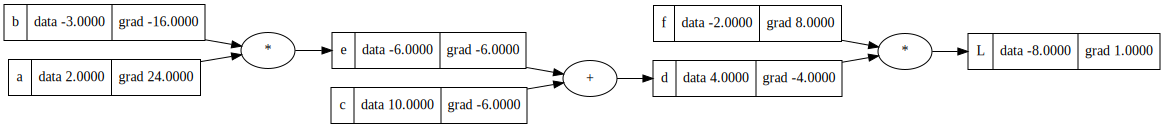

In [8]:
L.backward()
draw_plot(L)

In [7]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in the graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_plot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

- To observe : + node basically routes the gradient equally to the children
- Gradient nudging help us influence the final value !!!!! this is damn magical
- in w1*x1, if x1 = 0, then dL/dw1 = 0. hence for sparse features it's difficult to get influence of it's weight on loss. Hence difficult to converge, RMS prop to rescue( 2nd order moment )

In [55]:
import random

class Neuron:

  def __init__(self, nin):     # nin: no. of inputs to neuron
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # perform w * x + b
    act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    out = [neuron(x) for neuron in self.neurons]
    return out[0] if len(out) == 1 else out

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]



class MLP:

  def __init__(self, nin, nouts):
    sizes = [nin] + nouts
    self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [56]:
n = MLP(3, [2, 4, 3, 1])

In [41]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


[Value(data=0.8068236924973379),
 Value(data=0.8137811884109403),
 Value(data=0.771358835104767),
 Value(data=0.8073108750689968)]

In [59]:
for i in range(50):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))

  for p in n.parameters():
    p.grad = 0

  loss.backward()

  # update
  for p in n.parameters():
    p.data -= 0.05 * p.grad

  print(i, loss.data)


0 0.013626284808494597
1 0.01331421598016214
2 0.013015930174226404
3 0.012730540699540417
4 0.012457234959869003
5 0.012195266899312822
6 0.011943950351159052
7 0.011702653166835685
8 0.011470792020485999
9 0.011247827800346387
10 0.011033261511185817
11 0.01082663062301965
12 0.01062750581051302
13 0.010435488035251846
14 0.010250205929622405
15 0.010071313446612086
16 0.009898487744579208
17 0.009731427280086389
18 0.009569850085348724
19 0.009413492209817303
20 0.009262106307969597
21 0.009115460357579123
22 0.008973336494638155
23 0.008835529952754065
24 0.008701848096269968
25 0.008572109537603713
26 0.008446143330384627
27 0.008323788230914087
28 0.008204892021305117
29 0.008089310888384965
30 0.00797690885308154
31 0.00786755724557902
32 0.0077611342220228665
33 0.007657524318993213
34 0.0075566180423527075
35 0.007458311487419511
36 0.00736250598771994
37 0.007269107789846932
38 0.007178027752192651
39 0.007089181065536927
40 0.007002486993667744
41 0.006917868632379832
42 0.0

In [60]:
ypred

[Value(data=0.9639005827553226),
 Value(data=-0.9693603768520523),
 Value(data=-0.9550504938845772),
 Value(data=0.9547771434406386)]